In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pwd

'/content'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
from google.colab import drive
ROOT = '/content/drive'
drive.mount(ROOT)

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
ls

 CDC_2020/                       Project/
'Chest Xray v1.2.ipynb'         'Revised TAC Special Issue'/
'Colab Notebooks'/               Sergio.pdf
 cpe_proj/                       sim/
'Getting started.pdf'            Virtual_sully.gdoc
'Intro to BMIs Guest Lecture'/  'Virtual Sully Project'/
 new2020papers/                  xrays/
'PHD reports'/


# Loading dataset 

In [ ]:
TRAINDIR = "xrays/train"
VALDIR = "xrays/val"
TESTDIR = "xrays/test"

In [ ]:
type(TRAINDIR)


str

# using VGG16 convolutional layers as feature extractor:
## the VGG16 here is pre-trained by IMAGENET dataset

In [ ]:
IMG_W, IMG_H = 224, 224

In [ ]:
#Instantiate convolutional base

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_W, IMG_H, 3)) #include_top=False : to exclude the fully connected layers of the CNN

#Show Architecture
conv_base.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
# importing higher-level copy and write functions as well as ImageDataGenerator
import os, shutil
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Defining function for feature extraction and label creation

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 12 # the Size of the batches of data. Default: 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,3)) # 3 is the number of labels in our dataset
    # Preprocessing data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(IMG_W,IMG_H),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    
    # Passing data through convolutional-base layers
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) # predict function gives the features (it uses conv_base the output of VGG code from the 2-last code section)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels



In [ ]:
#Calling the feature extraction function on the train, test and validation datasets
#For running the model, train_features would be X_train and train_labels would be y_train

train_features, train_labels = extract_features(TRAINDIR,760) # Total no. of files in train folder
val_features, val_labels = extract_features(VALDIR, 95)
test_features, test_labels = extract_features(TESTDIR,95)

Found 760 images belonging to 3 classes.
Found 95 images belonging to 3 classes.
Found 95 images belonging to 3 classes.


In [ ]:
train_labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [ ]:
train_features.shape

(760, 7, 7, 512)

In [ ]:
#train_features[0].shape
train_labels.shape

(760, 3)

In [ ]:
# reshaping data as features x and their corresponding lables y for SVM
x_train = train_features.reshape(train_features.shape[0],-1)
y_train = np.argmax(train_labels, axis=1, out=None)

# validation data
x_valid = val_features.reshape(val_features.shape[0],-1)
y_valid = np.argmax(val_labels, axis=1, out=None)

# testing data
x_test = test_features.reshape(test_features.shape[0],-1)
y_test = np.argmax(test_labels, axis=1, out=None)

In [ ]:
x_train.shape, y_train.shape

((760, 25088), (760,))

## 760 componets with 25088 features => the curse of dimensionality 
addressed by Principal Component Analysis (PCA)

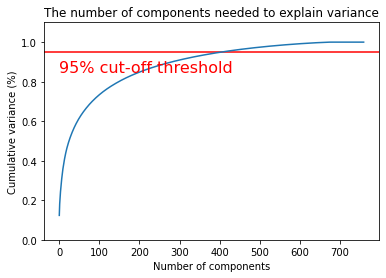

In [ ]:
# dimension reduction using PCA analysis

from sklearn.decomposition import PCA
fig, ax = plt.subplots()

plt.ylim(0.0,1.1)

plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

pca_chk = PCA() #
pca_chk.fit(x_train)
plt.plot(np.cumsum(pca_chk.explained_variance_ratio_))

plt.xlabel("Number of components")
plt.ylabel("Cumulative variance (%)")
plt.title('The number of components needed to explain variance')

plt.show()

# appying the *PCA*

In [ ]:
# dimension reduction using PCA analysis (cont'd)
n_pca_components=420
pca = PCA(n_components=n_pca_components)
train_pca = pca.fit_transform(x_train)
test_pca = pca.transform(x_test)
# train_pca = pca.transform(x_train)
# x_te = pca.transform(x_test)

# SVM for classification 

In [ ]:
# SVM
# a grid search is performed on a set of parameters and kernels to select the best classifier

from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [1, 10, 100], 'kernel': ['linear']},
  {'C': [1, 10, 100], 'gamma': [0.001, 0.0001] , 'degree': [1,2,3], 'kernel': ['poly']},
 ]

# C dentos the regularization parameter  and gamma denotes  th Kernel coeff.
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid, refit=True)
clf.fit(pca.transform(x_train), y_train) # pca.transform(x_train) transforms data into the principal components


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1, 10, 100], 'degree': [1, 2, 3],
                          'gamma': [0.001, 0.0001], 'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
clf.cv_results_

{'mean_fit_time': array([0.10419631, 0.10134268, 0.10364656, 0.1406384 , 0.22992625,
        0.25421534, 0.25429826, 0.26181784, 0.24225183, 0.10490966,
        0.13982625, 0.24917073, 0.25749607, 0.25764422, 0.2544929 ,
        0.10246825, 0.10478263, 0.25038481, 0.26346126, 0.25568304,
        0.26540051]),
 'mean_score_time': array([0.02369404, 0.02362585, 0.02477093, 0.03460188, 0.04692063,
        0.0476645 , 0.04839926, 0.04845562, 0.04839926, 0.02590909,
        0.03448505, 0.0434751 , 0.04845366, 0.04640021, 0.04830322,
        0.02411246, 0.0257349 , 0.042628  , 0.04989738, 0.04444747,
        0.04895468]),
 'mean_test_score': array([0.80789474, 0.80789474, 0.80789474, 0.85131579, 0.74605263,
        0.675     , 0.42105263, 0.51447368, 0.40789474, 0.84605263,
        0.85131579, 0.82105263, 0.42105263, 0.83947368, 0.40789474,
        0.81578947, 0.84605263, 0.79868421, 0.675     , 0.84605263,
        0.40789474]),
 'param_C': masked_array(data=[1, 10, 100, 1, 1, 1, 1, 1, 1, 10

In [ ]:
clf.best_estimator_

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma=0.001, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# y_pred_train = clf.predict(x_train)
y_pred_train = clf.predict(pca.transform(x_train))
# y_pred_valid = clf.predict(x_valid)
y_pred_valid = clf.predict(pca.transform(x_valid))
# y_pred_test = clf.predict(x_test)
y_pred_test = clf.predict(pca.transform(x_test))

In [ ]:
y_pred_valid.shape

(95,)

Accuracy on tranining set =  0.925


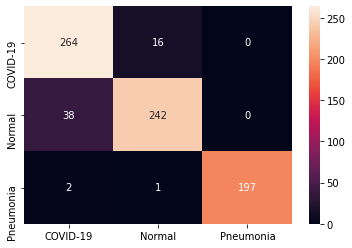

In [ ]:
# Print overall accuracy of TRAIN
# from sklearn.metrics import accuracy_score

from sklearn import metrics
print ("Accuracy on tranining set = ", metrics.accuracy_score(y_train, y_pred_train))

# Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

fig100 = plt.figure()
categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(y_train, y_pred_train)
#print(cm)
sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')

Accuracy on validation set =  0.8421052631578947


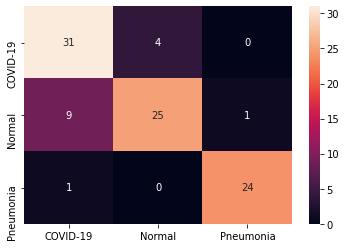

In [ ]:
# Print overall accuracy of Validation
# from sklearn.metrics import accuracy_score

from sklearn import metrics
print ("Accuracy on validation set = ", metrics.accuracy_score(y_valid, y_pred_valid))

# Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

fig100 = plt.figure()
categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(y_valid, y_pred_valid)
#print(cm)
sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')

Accuracy on testing set =  0.042105263157894736


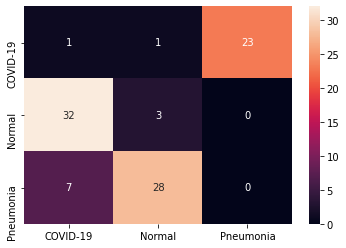

In [ ]:
# Print overall accuracy of TEST
print ("Accuracy on testing set = ", metrics.accuracy_score(y_test, y_pred_test))

categories = ['COVID-19','Normal','Pneumonia']
cm = confusion_matrix(y_test, y_pred_test)
#print(cm)
sns.heatmap(cm, xticklabels =categories , yticklabels =categories, annot=True, fmt='d')

# Visualization of feature maps

In [ ]:
# libraries required to plot the feature map of the first conv layer for a given image

from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model

Filters (weights):

In [ ]:
# the VGG16 has 5 blocks of ConvNet layers. we now show  the weights in each block that represent the filters that if being applied generates the feature maps
# summarize filter shapes
for layer in conv_base.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


the above result shows that all convolutional layers use 3×3 filters. 
We next plot the feature maps associated with each block i.e. pass data through Conv. layers to be processed by filters and plot the output that are features; finally plotting the results

Visualizing Feature Maps

In [ ]:
# redefine conv_base to the output right after the "1st" hidden layer
model = Model(inputs=conv_base.inputs, outputs=conv_base.layers[1].output)
model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# load an image from our dataset with the required shape
img = load_img('xrays/train/covid19/1-s2.0-S0929664620300449-gr2_lrg-a.jpg', target_size=(224, 224))
# now, the image PIL object needs to be converted to a NumPy array of pixel data and 
# expanded from a 3D array to a 4D array with the dimensions of
# [samples, rows, cols, channels], where we only have one sample.
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)

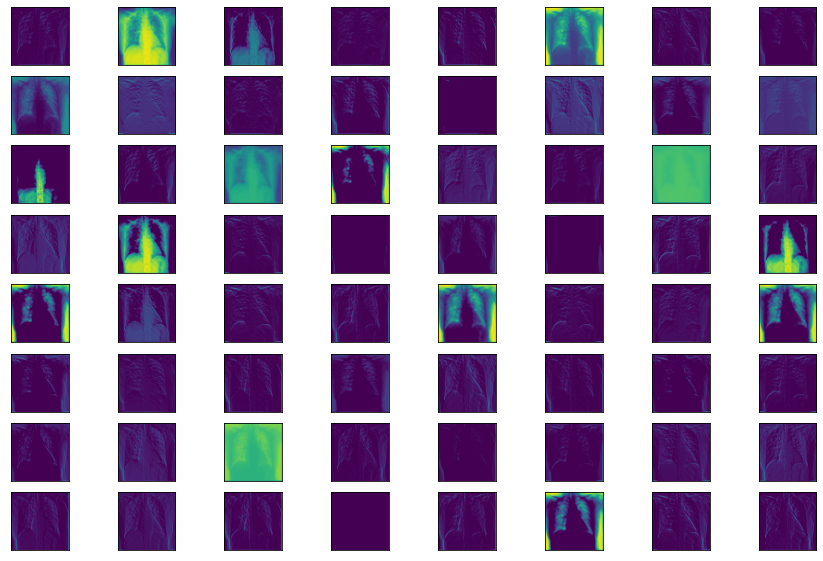

In [ ]:
# get feature map for the first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
fig1 = plt.figure()
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1])
#   plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
fig1.set_size_inches(15,10)
plt.show()

# the result shows different features highlighted. Some of them highlight lines and/or the texture of the lungs, and others focus on the background or the foreground.

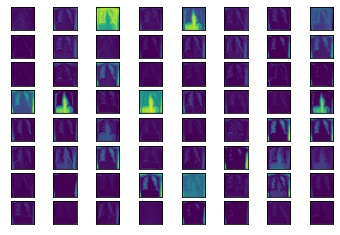

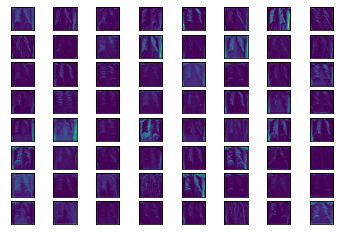

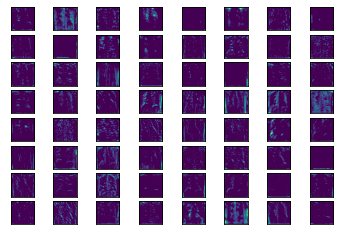

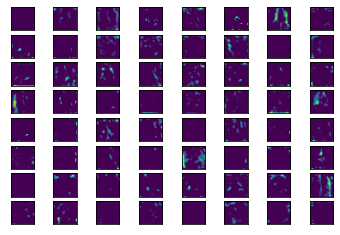

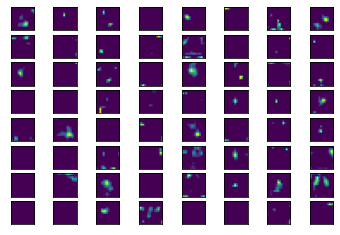

In [ ]:
# redefine model to output right after the each hidden layer 
# Given the structure of VGG16 the layer indexes of the last convolutional layer in each block are [2, 5, 9, 13, 17].
ixs = [2, 5, 9, 13, 17] 
outputs = [conv_base.layers[i].output for i in ixs]
model = Model(inputs=conv_base.inputs, outputs=outputs)
# load an image from our dataset with the required shape
img = load_img('xrays/train/covid19/1-s2.0-S0929664620300449-gr2_lrg-a.jpg', target_size=(224, 224))
# now, the image PIL object needs to be converted to a NumPy array of pixel data and 
# expanded from a 3D array to a 4D array with the dimensions of
# [samples, rows, cols, channels], where we only have one sample.
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = plt.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			plt.imshow(fmap[0, :, :, ix-1])
      # plt.imshow(fmap[0, :, :, ix-1], cmap='viridis') # or gray
			ix += 1
	# show the figure
	plt.show()

# the same procedures can be applied to VGG19 or other CNN arcituectures




In [ ]:
# train_features, train_labels

x_train_features = train_features.reshape(train_features.shape[0],-1)

In [ ]:
from keras.applications import VGG19
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_W, IMG_H, 3))

vgg19_base.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________